In [1]:
import torch_geometric
import data_utils
import model
import torch
from torch_geometric.utils import to_dense_adj
import matplotlib.pyplot as plt
import networkx as nx
import time
import sklearn

In [2]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

transform = T.Compose([
    T.NormalizeFeatures(),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
dataset_name = 'cora'
dataset = Planetoid('../dataset', dataset_name, transform=transform)
train_data, val_data, test_data = dataset[0]


def visualize_graph(G, color, pos=None):
    #plt.figure(figsize=(7,7))
    #plt.xticks([])
    #plt.yticks([])
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    if pos == None:
        pos=nx.spring_layout(G, seed=42)
    nx.draw_networkx(G,  with_labels=False,
                     node_color=color, cmap="Set2", node_size=2, arrows=False)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    #plt.xticks([])
    #plt.yticks([])
    #plt.xlim([-2,2])
    #plt.ylim([-2,2])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=20, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    #plt.show()

In [3]:
import importlib
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
embedding_dim = 2

class VariationalGCN(torch.nn.Module):
    def __init__(self, num_features, embedding_dim, params):
        super().__init__()
        self.conv1 = GCNConv(num_features, 2*embedding_dim)
        self.mu_encoder = GCNConv(2*embedding_dim, embedding_dim)
        self.logstd_encoder = GCNConv(2*embedding_dim, embedding_dim)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.mu_encoder(x, edge_index), self.logstd_encoder(x, edge_index)
    
class VariationalGAT(torch.nn.Module):
    def __init__(self, num_features, embedding_dim, params):
        super().__init__()
        self.conv1 = GATConv(num_features, 2*embedding_dim, heads=params["heads"], concat=False)
        self.mu_encoder = GATConv(2*embedding_dim, embedding_dim, heads=params["heads"], concat=False)
        self.logstd_encoder = GATConv(2*embedding_dim, embedding_dim, heads=params["heads"], concat=False)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.mu_encoder(x, edge_index), self.logstd_encoder(x, edge_index)

class VariationalSAGE(torch.nn.Module):
    def __init__(self, num_features, embedding_dim, params):
        super().__init__()
        self.conv1 = SAGEConv(num_features, 2*embedding_dim, aggr=params["aggr"])
        self.mu_encoder = SAGEConv(2*embedding_dim, embedding_dim, aggr=params["aggr"])
        self.logstd_encoder = SAGEConv(2*embedding_dim, embedding_dim, aggr=params["aggr"])
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.mu_encoder(x, edge_index), self.logstd_encoder(x, edge_index)

vae = torch_geometric.nn.models.VGAE(
    encoder=VariationalSAGE(dataset.num_features, embedding_dim, {"aggr": "mean"}),
    decoder=None
)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.05)  # Define optimizer.


def train(vae, data):
    vae.train()
    optimizer.zero_grad()  # Clear gradients.

    z = vae.encode(data.x, data.edge_index)

    recon_loss = vae.recon_loss(z, data.pos_edge_label_index)
    kld = vae.kl_loss()

    loss = recon_loss + 1/data.num_nodes * kld


    # OPTIMIZATION STEP
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.


    return float(loss), vae.decode(z, data.edge_index), z, float(kld), float(recon_loss)


@torch.no_grad()
def test(vae, data):
    vae.eval()
    z = vae.encode(data.x, data.edge_index)
    return vae.test(z, data.pos_edge_label_index, data.neg_edge_label_index), vae.recon_loss(z, data.pos_edge_label_index), vae.kl_loss()

losses = []

epochs = 1000
if False:
    for epoch in range(epochs):
        loss, A_recon, z, kld, recon_loss = train(vae,train_data)
        with torch.no_grad():
            #train_accuracy = torch.equal(torch.greater_equal(A_recon, 0.5).float(), train_data.edge_index)
            auc, ap, _, _ = test(val_data)
            losses.append([loss, kld, recon_loss, auc, ap])
            if epoch % 50 == 0 and embedding_dim == 2:
                visualize_embedding(z, color=train_data.y, epoch=epoch, loss=torch.tensor(loss))
                time.sleep(0.3)

# Train with different parameters

In [6]:
import sklearn.model_selection
import pandas as pd
from tqdm import tqdm


gcn_params = {
    "embedding_dim": [2,3,4,5,10,20]
}
gat_params = {
    "embedding_dim": [2,3,4,5,10,20],
    "heads": [1,2,3,4,5]
}
sage_params = {
    "embedding_dim": [2,3,4,5,10,20],
    "aggr": ["mean", "min", "max"]
}
gcn_set = sklearn.model_selection.ParameterGrid(gcn_params)
gat_set = sklearn.model_selection.ParameterGrid(gat_params)
sage_set = sklearn.model_selection.ParameterGrid(sage_params)
total = [(VariationalGCN, s) for s in gcn_set] + [(VariationalGAT, s) for s in gat_set] + [(VariationalSAGE, s) for s in sage_set]

#results = pd.DataFrame(columns=["model", "step", "embedding_dim", "params", "train_kld", "train_recon_loss", "val_auc", "val_ap", "val_kld", "val_recon_loss"])
results = []
test_results = []
for (model_constructor, params) in tqdm(total):
    model = torch_geometric.nn.models.VGAE(encoder=model_constructor(dataset.num_features, params["embedding_dim"], params))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Define optimizer.
    epochs = 300
    for epoch in range(epochs):
        loss, A_recon, z, kld, recon_loss = train(model, train_data)
        if epoch % 10:
            with torch.no_grad():
                (auc, ap), val_recon_loss, val_kld = test(model, val_data)
                #visualize_embedding(z, color=train_data.y, epoch=epoch, loss=torch.tensor(loss))
                results.append({
                    "model": model_constructor.__name__,
                    "step": epoch,
                    "embedding_dim": params["embedding_dim"],
                    "params": str(params),
                    "train_kld": kld,
                    "train_recon_loss": recon_loss,
                    "val_auc": auc,
                    "val_ap": ap,
                    "val_kld": val_kld,
                    "val_recon_loss": val_recon_loss
                })
    escape = lambda x: x.replace("_", "")
    param_string = "_".join([f"{escape(key)}={item}" for key, item in params.items()])
    torch.save(model.state_dict(), f"saved_models/name={model_constructor.__name__}_{param_string}_epochs={epochs}")


100%|██████████| 54/54 [15:32<00:00, 17.27s/it]


# Visualize losses
**NOTES**:
- KLD:
    - From plots, looks like higher embedded spaces give worse KL divergence 
    - Interpretation: KL divergence measures how close the $z$'s are to a standard gaussian distribution. As embedded space increases, a standard gaussian becomes more and more sparse. Worth mentioning
- Reconstruction loss:
    - This is the binary cross entropy on edges predicted. It measures how well the embedded space gets decoded to an adjacency matrix. Remember that the decoder is not trainable.
    - Interpretation: It looks like all three encoders first transform the embedded nodes into something thats very non-gaussian, but improves reconstruction loss a lot, then tries to deform it into something more gaussian. When KLD is large, the gradient is pointing very much against a pulling things to a normal-ish distribution, which leads to little-to-no improvements in reconstruction loss. GraphSAGE is more efficient at skipping this initial stage with bad KLD and quickly improves reconstruction loss.
- AUC/AP:
    - AUC = area under ROC curve = "given positive and negative sample, probability that positive is ranked higher than negative". In this case "positive sample" and "negative sample" are two pairs of nodes, which is positive if there exists an edge between them and negative otherwise
    - AP = average precision
    - These are computed on validation set
    - No real improvement is seen until KLD becomes managable! (after the "bump").
    - In general higher embedded spaces give better performance (not surprising)
    - The best performing model is a GCN (surprising! Is it reproducable however?)

/tmp/ipykernel_7313/2086181175.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records["head"] = records["params"].apply(lambda x: eval(x)["heads"])
/tmp/ipykernel_7313/2086181175.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records["head"] = records["params"].apply(lambda x: eval(x)["heads"])
/tmp/ipykernel_7313/2086181175.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

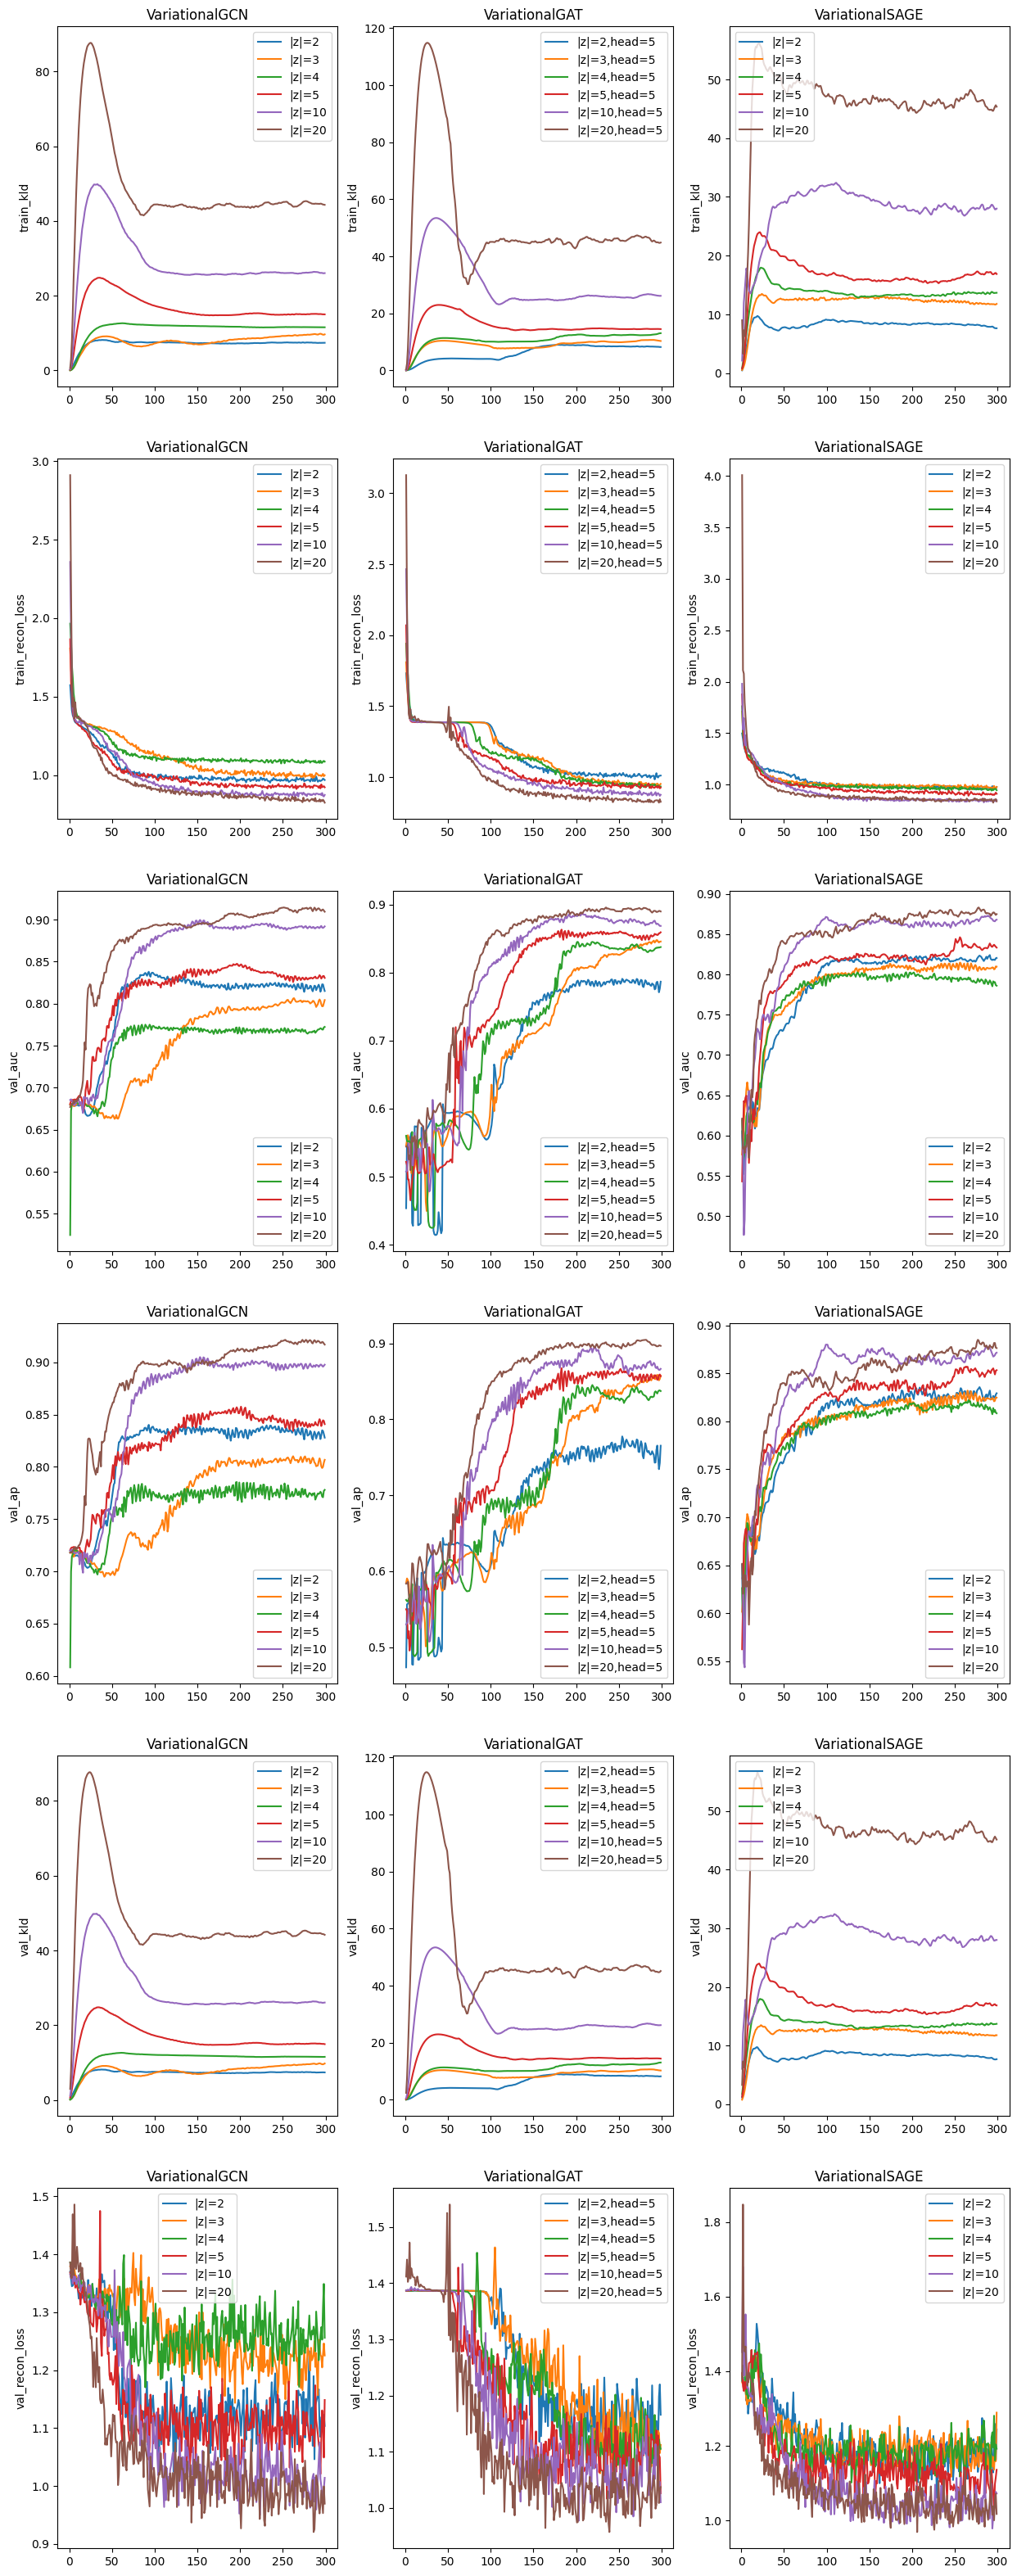

In [7]:
df = pd.DataFrame.from_dict(results)
metrics = ["train_kld", "train_recon_loss", "val_auc", "val_ap", "val_kld", "val_recon_loss"]
fig, axs = plt.subplots(len(metrics),3, figsize=(15,40))
for row_idx, metric in enumerate(metrics):
    for idx, model_type in enumerate(["VariationalGCN", "VariationalGAT", "VariationalSAGE"]):
        if model_type == "VariationalGCN":
            for embedding_dim in [2,3,4,5, 10, 20]:
                records = df.loc[(df["embedding_dim"] == embedding_dim) & (df["model"] == model_type)]
                axs[row_idx,idx].plot(records["step"], records[metric], label=f"|z|={embedding_dim}")
        if model_type == "VariationalGAT":
            for embedding_dim in [2,3,4,5, 10, 20]:
                records = df.loc[(df["embedding_dim"] == embedding_dim) & (df["model"] == model_type)]
                records["head"] = records["params"].apply(lambda x: eval(x)["heads"])
                r = records[records["head"] == 5]
                axs[row_idx,idx].plot(r["step"], r[metric], label=f"|z|={embedding_dim},head={5}")
        if model_type == "VariationalSAGE":
            for embedding_dim in [2,3,4,5, 10, 20]:
                records = df.loc[(df["embedding_dim"] == embedding_dim) & (df["model"] == model_type)]
                records["aggr"] = records["params"].apply(lambda x: eval(x)["aggr"])
                r = records[records["aggr"] == "max"]
                axs[row_idx,idx].plot(r["step"], r[metric], label=f"|z|={embedding_dim}")
        axs[row_idx,idx].legend()
        axs[row_idx,idx].set_title(model_type)
        axs[row_idx,idx].set_ylabel(metric)

In [89]:
df["params"]

0                       {'embedding_dim': 2}
1                       {'embedding_dim': 2}
2                       {'embedding_dim': 2}
3                       {'embedding_dim': 2}
4                       {'embedding_dim': 2}
                        ...                 
4855    {'aggr': 'max', 'embedding_dim': 20}
4856    {'aggr': 'max', 'embedding_dim': 20}
4857    {'aggr': 'max', 'embedding_dim': 20}
4858    {'aggr': 'max', 'embedding_dim': 20}
4859    {'aggr': 'max', 'embedding_dim': 20}
Name: params, Length: 4860, dtype: object

In [12]:
import os
test_results = []
for model_path in os.listdir("saved_models"):
    model_constructor = eval(model_path.split("_")[0].split("=")[1])
    embedding_dim = int([p.split("=") for p in model_path.split("_") if p.split("=")[0] == "embeddingdim"][0][1])
    heads = int(model_path.split("heads=")[1].split("_")[0]) if "heads" in model_path else None
    aggr = model_path.split("aggr=")[1].split("_")[0].split("-")[0] if "aggr" in model_path else None
    model = torch_geometric.nn.models.VGAE(model_constructor(dataset.num_features, embedding_dim, {
        "heads": heads,
        "aggr": aggr
    }))
    model_path = os.path.join("saved_models", model_path)
    
    model.load_state_dict(torch.load(model_path, weights_only=True))
    with torch.no_grad():
        (auc, ap), recon, kld = test(model, test_data)
        test_results.append({
            "model_name": model_constructor.__name__,
            "auc": auc,
            "ap": ap,
            "recon": recon,
            "kld": kld,
            "heads": heads,
            "aggr": aggr,
            "parameters": sum(p.numel() for p in model.parameters()),
        })

Text(0, 0.5, 'Test AP')

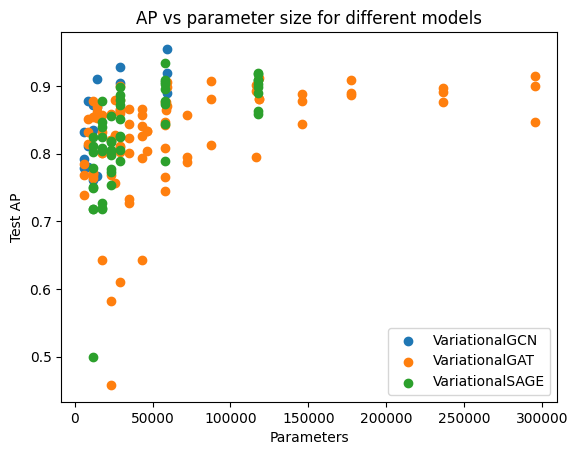

In [13]:
test_df = pd.DataFrame.from_dict(test_results)
colormap = {
    "VariationalGCN": "green",
    "VariationalGAT": "red",
    "VariationalSAGE": "blue",
}
for model_type in colormap.keys():
    r = test_df[test_df["model_name"] == model_type]
    plt.scatter(r["parameters"], r["ap"], label=model_type)
plt.title("AP vs parameter size for different models")
plt.xlabel("Parameters")
plt.legend()
plt.ylabel("Test AP")

Text(0, 0.5, 'Average Precision')

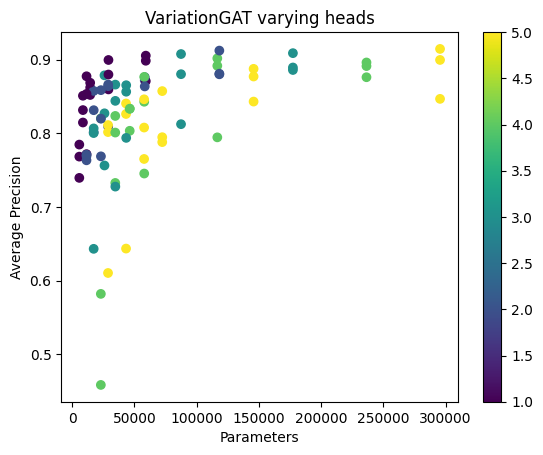

In [14]:
test_gats = test_df[test_df["model_name"] == "VariationalGAT"]
plt.scatter(test_gats["parameters"], test_gats["ap"], c=test_gats["heads"])
plt.colorbar()
plt.xlabel("Parameters")
plt.title("VariationGAT varying heads")
plt.ylabel("Average Precision")

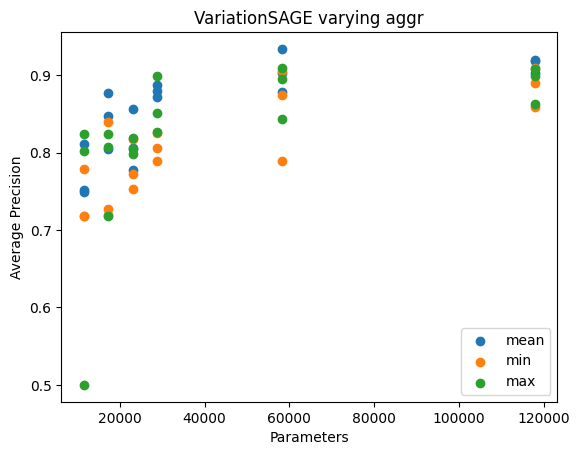

In [15]:
for aggr in sage_params["aggr"]:
    test_gats = test_df[(test_df["model_name"] == "VariationalSAGE") & (test_df["aggr"] == aggr)]
    plt.scatter(test_gats["parameters"], test_gats["ap"], label=aggr)
    plt.legend()
    plt.xlabel("Parameters")
    plt.title("VariationSAGE varying aggr")
    plt.ylabel("Average Precision")

/tmp/ipykernel_7313/747258786.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,7))


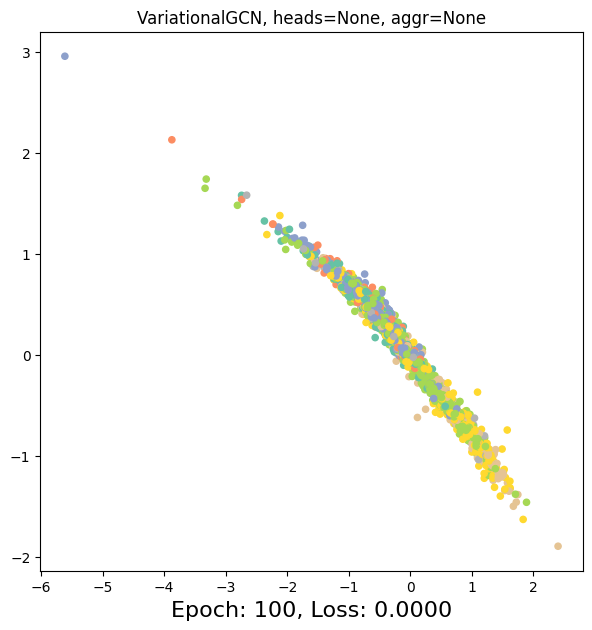

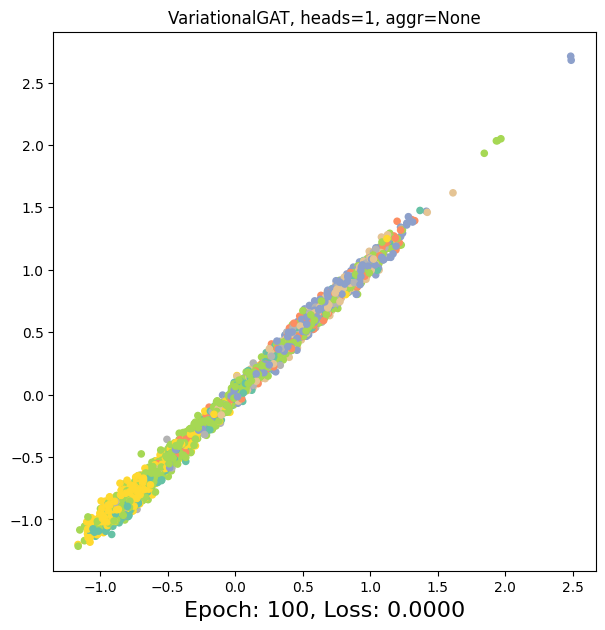

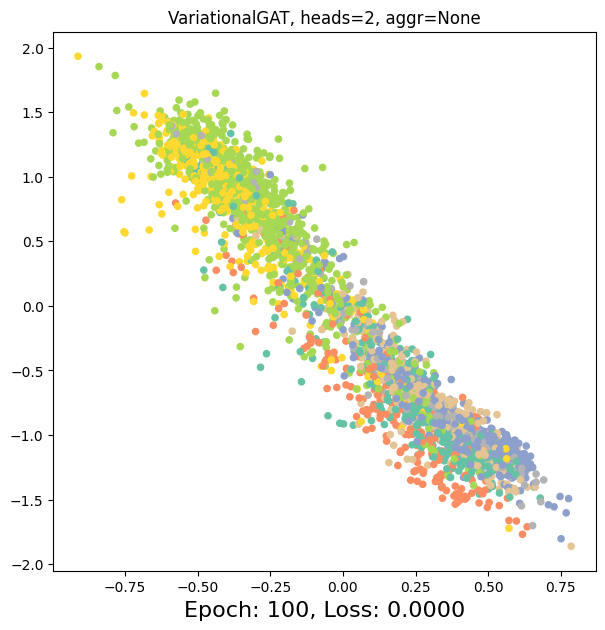

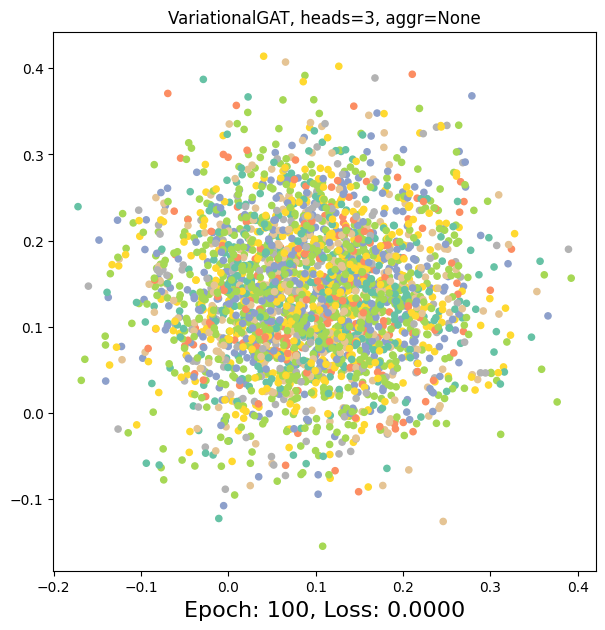

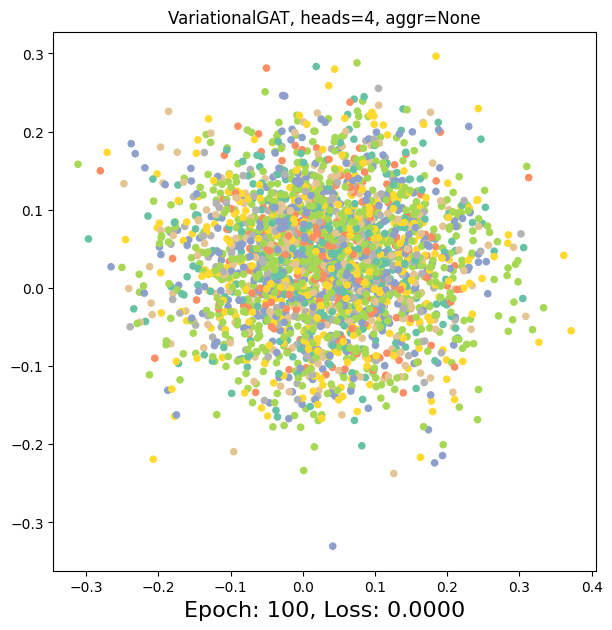

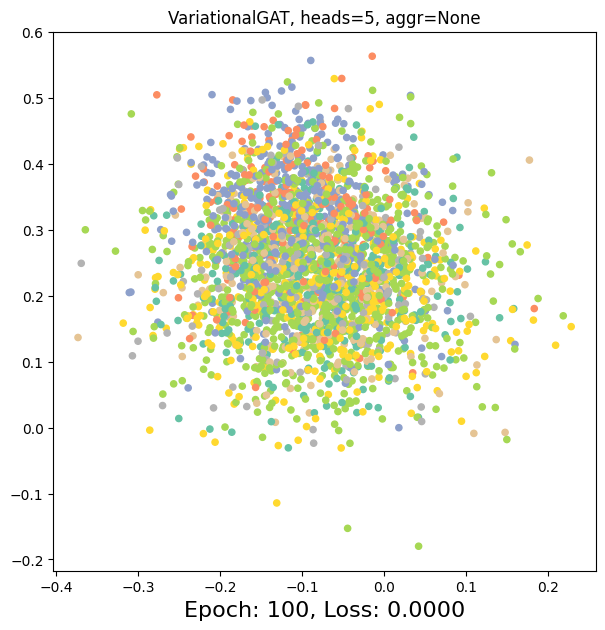

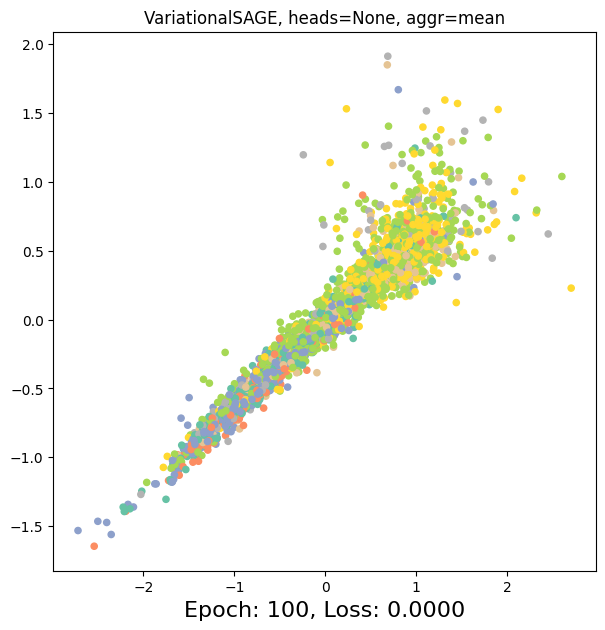

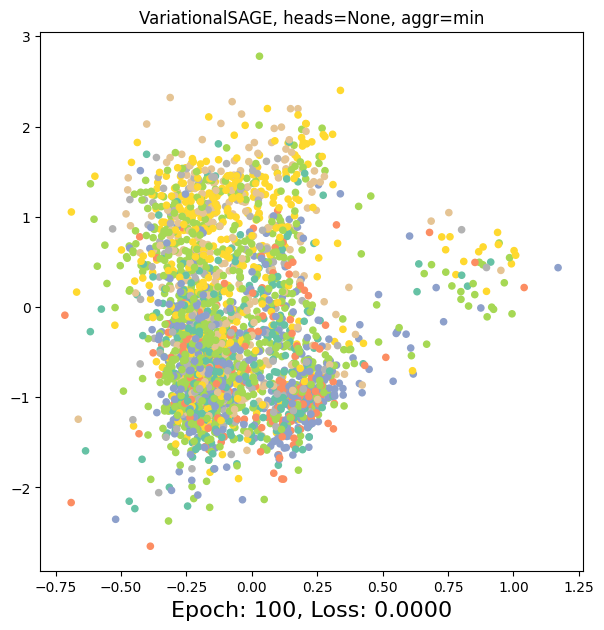

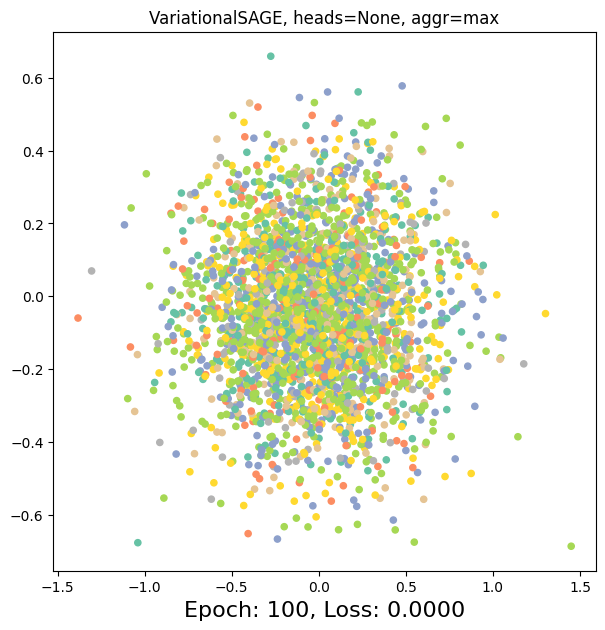

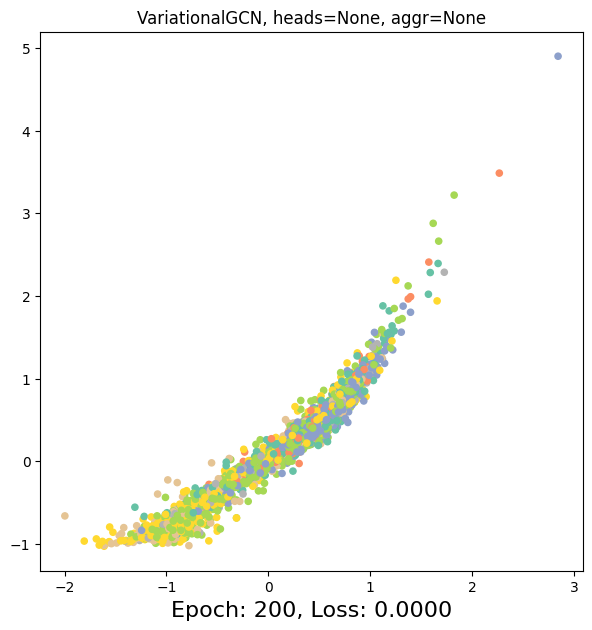

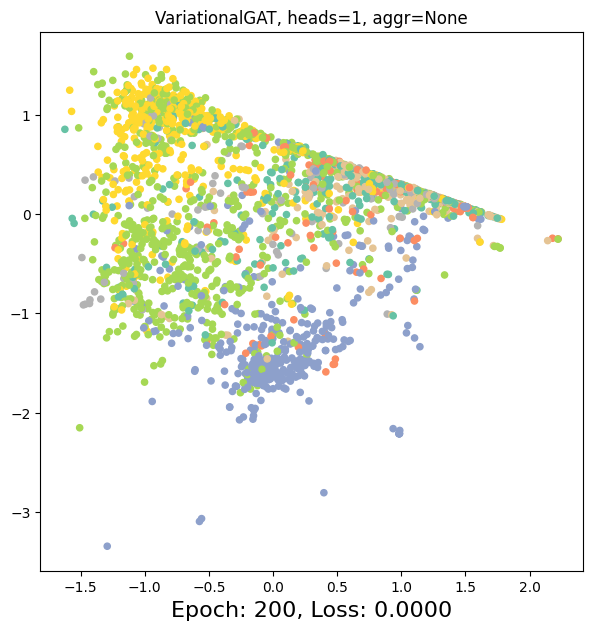

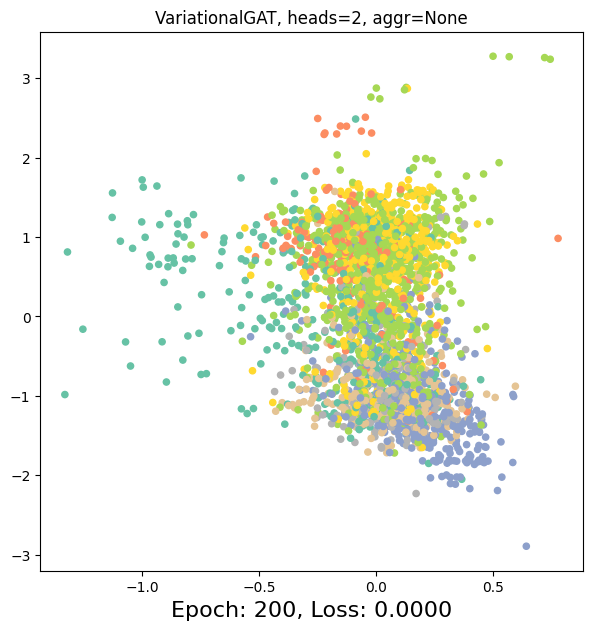

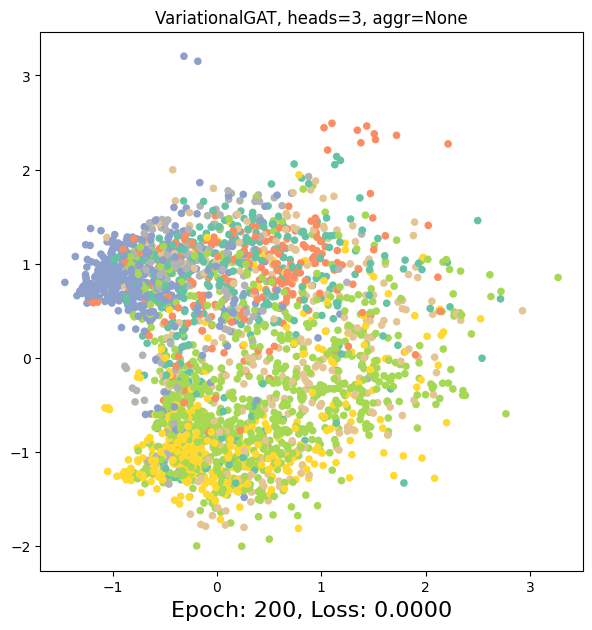

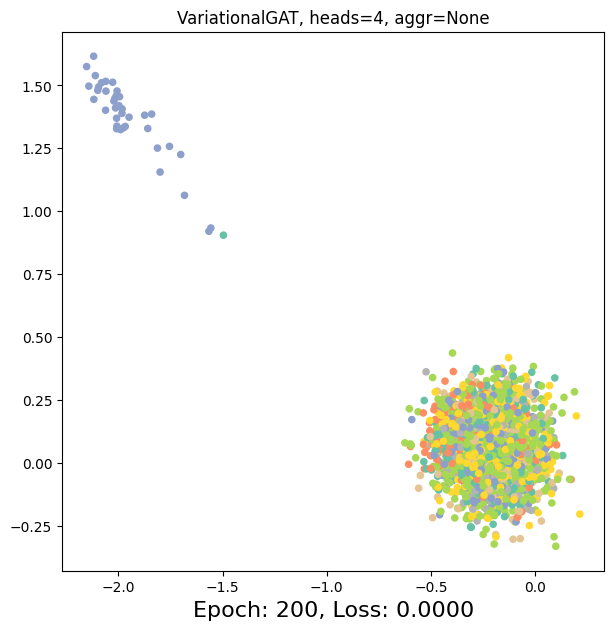

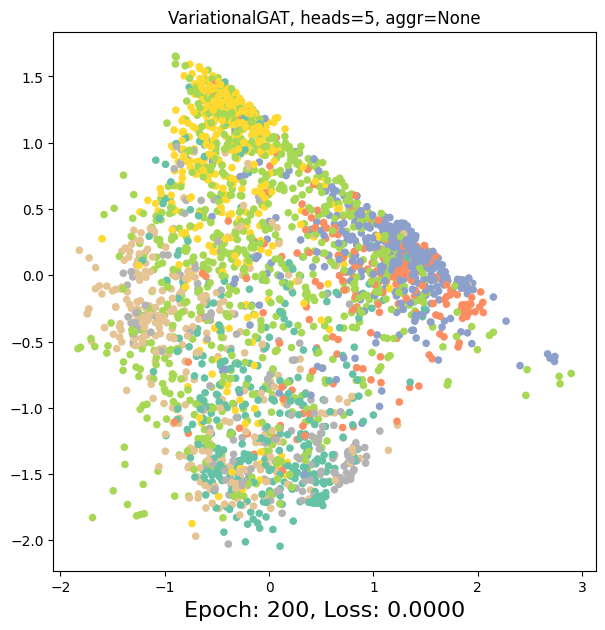

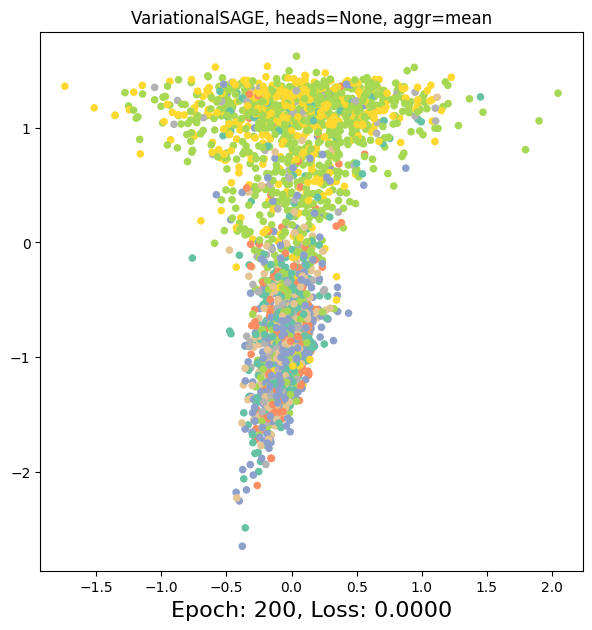

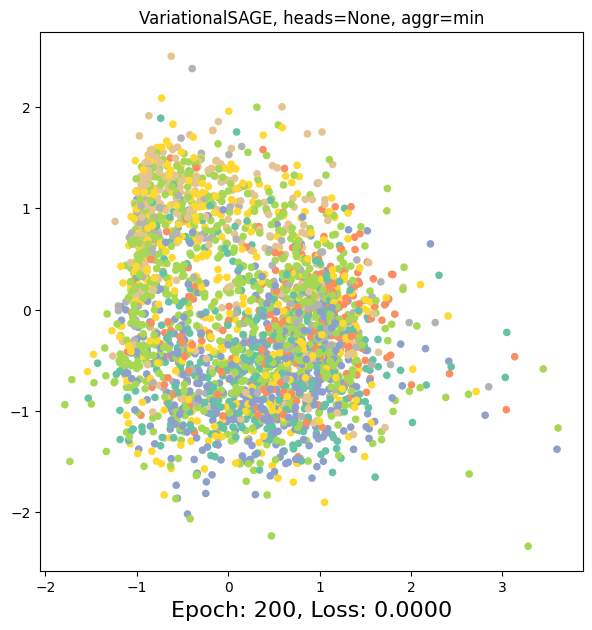

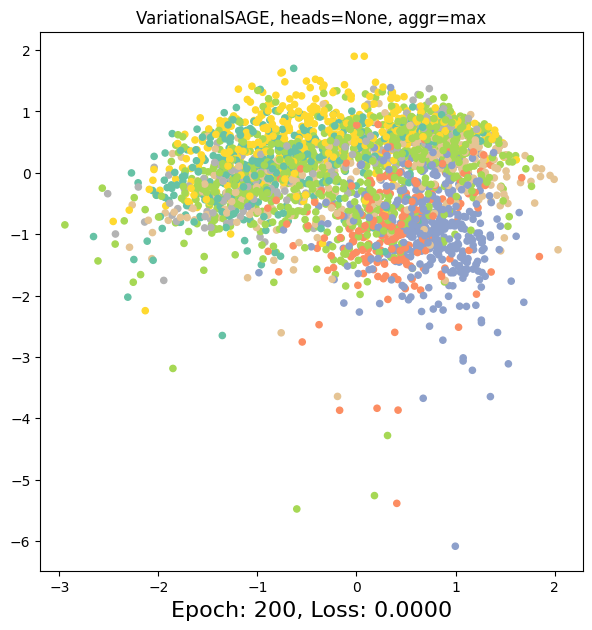

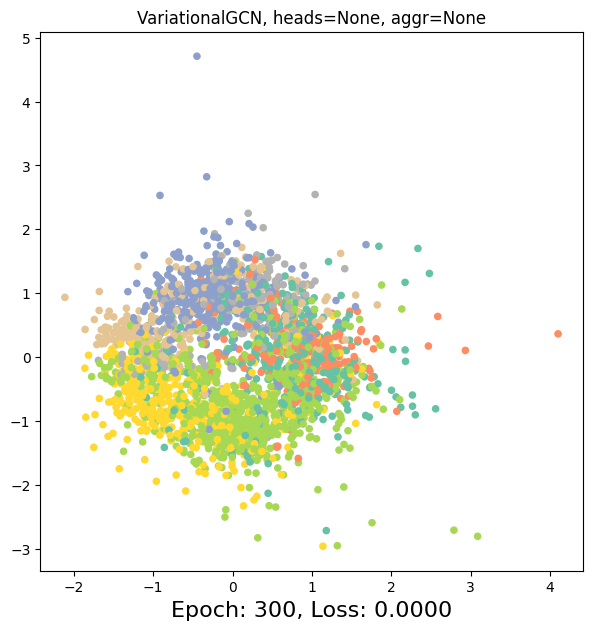

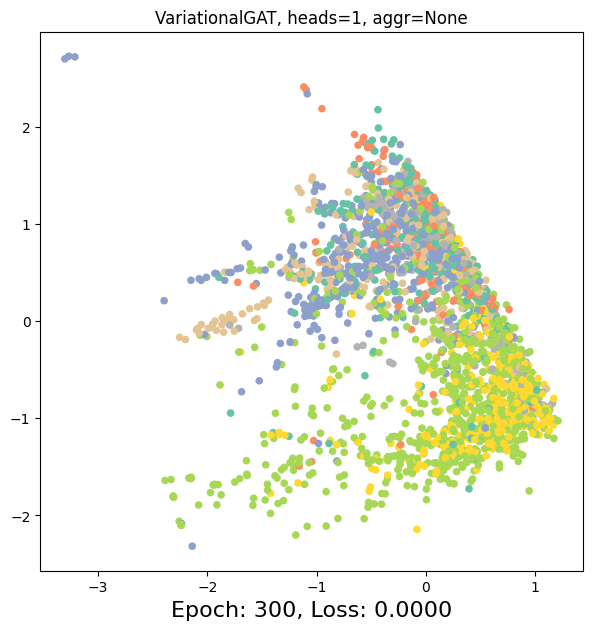

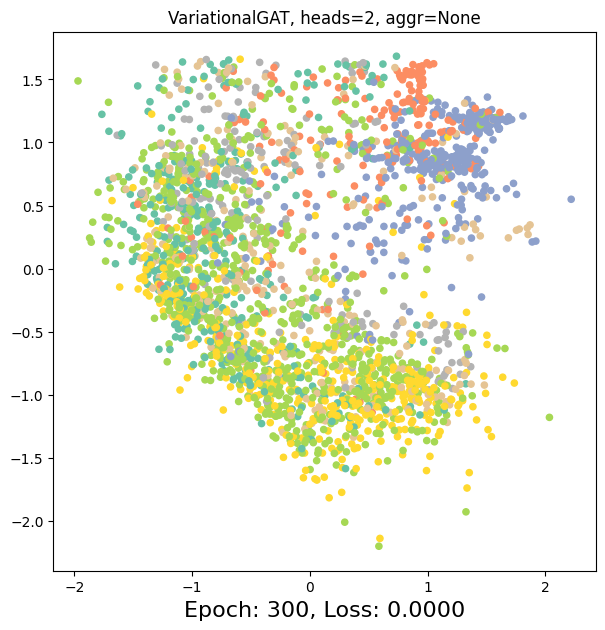

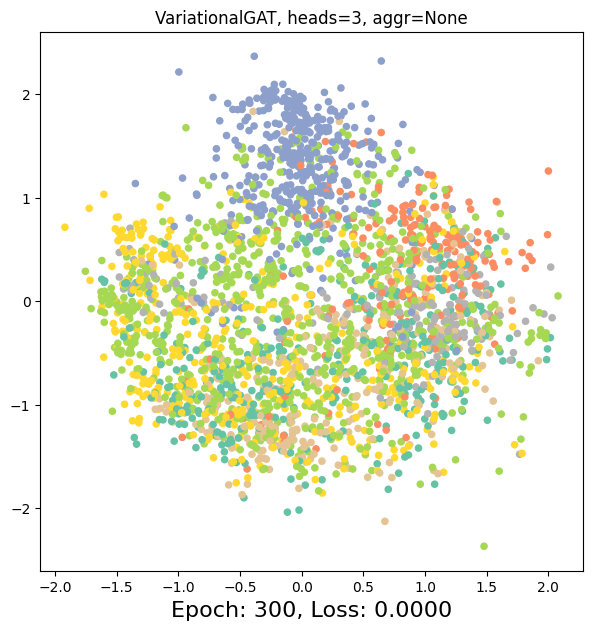

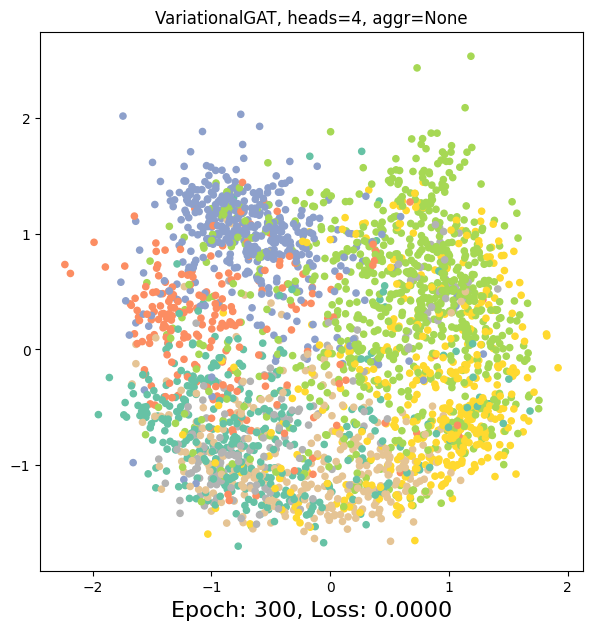

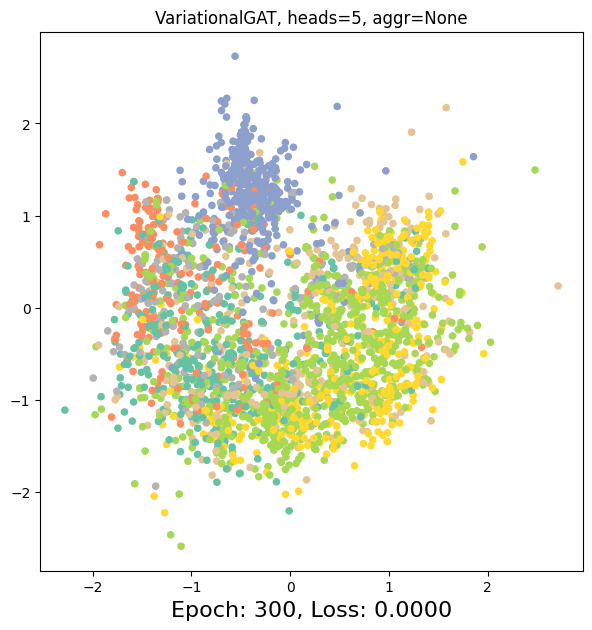

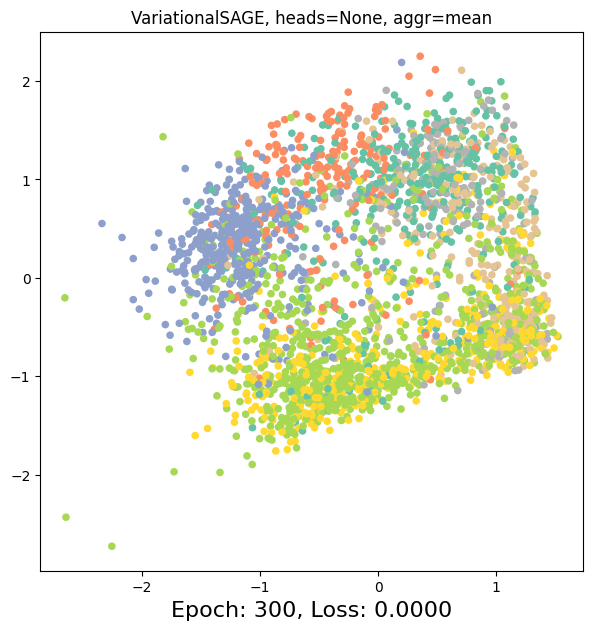

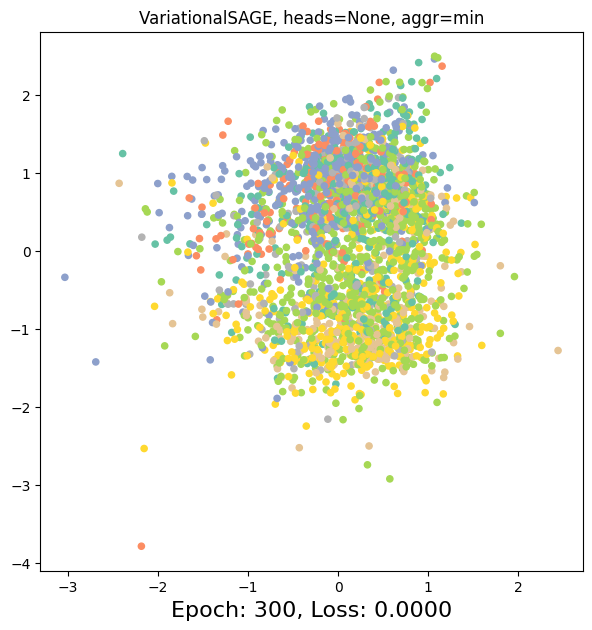

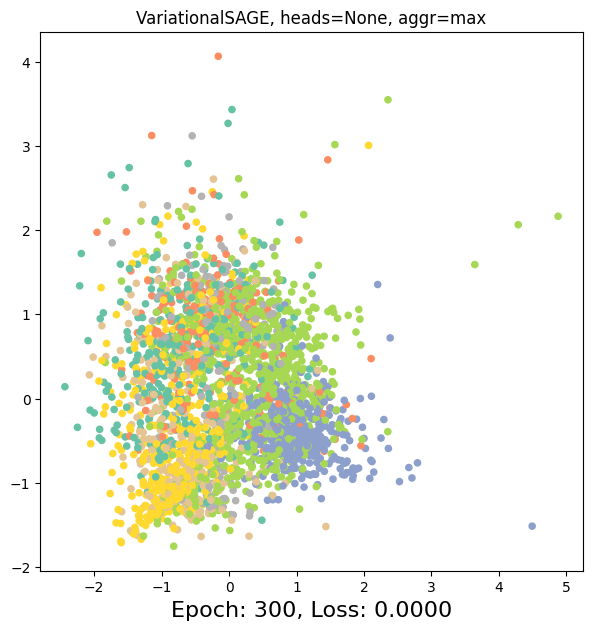

In [21]:

import os
test_results = []
for model_path in os.listdir("saved_models"):
    model_constructor = eval(model_path.split("_")[0].split("=")[1])
    embedding_dim = int([p.split("=") for p in model_path.split("_") if p.split("=")[0] == "embeddingdim"][0][1])
    if embedding_dim > 2:
        continue
    heads = int(model_path.split("heads=")[1].split("_")[0]) if "heads" in model_path else None
    aggr = model_path.split("aggr=")[1].split("_")[0].split("-")[0] if "aggr" in model_path else None
    model = torch_geometric.nn.models.VGAE(model_constructor(dataset.num_features, embedding_dim, {
        "heads": heads,
        "aggr": aggr
    }))
    model_path = os.path.join("saved_models", model_path)
    epochs = int(model_path.split("epochs=")[1])
    
    model.load_state_dict(torch.load(model_path, weights_only=True))
    with torch.no_grad():
        z = model.encode(test_data.x, test_data.edge_index)
        A = model.decode(z, test_data.edge_index)
        visualize_embedding(z, color=test_data.y, epoch=epochs, loss=torch.tensor(0))
        plt.title(f"{model_constructor.__name__}, heads={heads}, aggr={aggr}")


# Getting the best possible model
GCN vs GAT vs GraphSAGE:
heads = 1,
aggr = mean

In [4]:
from tqdm import trange
experiments_per = 12
embedding_dim = 2
epochs = 300
gcn_results = []
gat_results = []
sage_results = []


def eval_model(model, params, results, idx, model_name):
    for epoch in range(epochs):
        loss, A_recon, z, kld, recon_loss = train(model, train_data)
        if epoch % 10:
             with torch.no_grad():
                (auc, ap), val_recon_loss, val_kld = test(model, val_data)
                #visualize_embedding(z, color=train_data.y, epoch=epoch, loss=torch.tensor(loss))
                results.append({
                    "idx": idx,
                    "model": model_name,
                    "step": epoch,
                    "embedding_dim": embedding_dim,
                    "params": str(params),
                    "train_kld": kld,
                    "train_recon_loss": recon_loss,
                    "val_auc": auc,
                    "val_ap": ap,
                    "val_kld": val_kld,
                    "val_recon_loss": val_recon_loss
                })
    escape = lambda x: x.replace("_", "")
    param_string = "_".join([f"{escape(key)}={item}" for key, item in params.items()])
    torch.save(model.state_dict(), f"repeat_experiment_models/name={model_name}_{param_string}_epochs={epochs}_idx={idx}")
# VariationalGCN
for i in trange(experiments_per):
    params = {}
    encoder = VariationalGCN(dataset.num_features, embedding_dim, params)
    model = torch_geometric.nn.models.VGAE(encoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Define optimizer.
    eval_model(model, params, gcn_results, i, VariationalGCN.__name__)

# VariationalGAT
for i in trange(experiments_per):
    params = {"heads": 1}
    encoder = VariationalGAT(dataset.num_features, embedding_dim, params)
    model = torch_geometric.nn.models.VGAE(encoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Define optimizer.
    eval_model(model, params, gat_results, i, VariationalGAT.__name__)


# VariationalSAGE
for i in trange(experiments_per):
    params = {"aggr": "mean"}
    encoder = VariationalSAGE(dataset.num_features, embedding_dim, params)
    model = torch_geometric.nn.models.VGAE(encoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Define optimizer.
    eval_model(model, params, sage_results, i, VariationalSAGE.__name__)

100%|██████████| 12/12 [05:16<00:00, 26.39s/it]


In [7]:

import pandas as pd

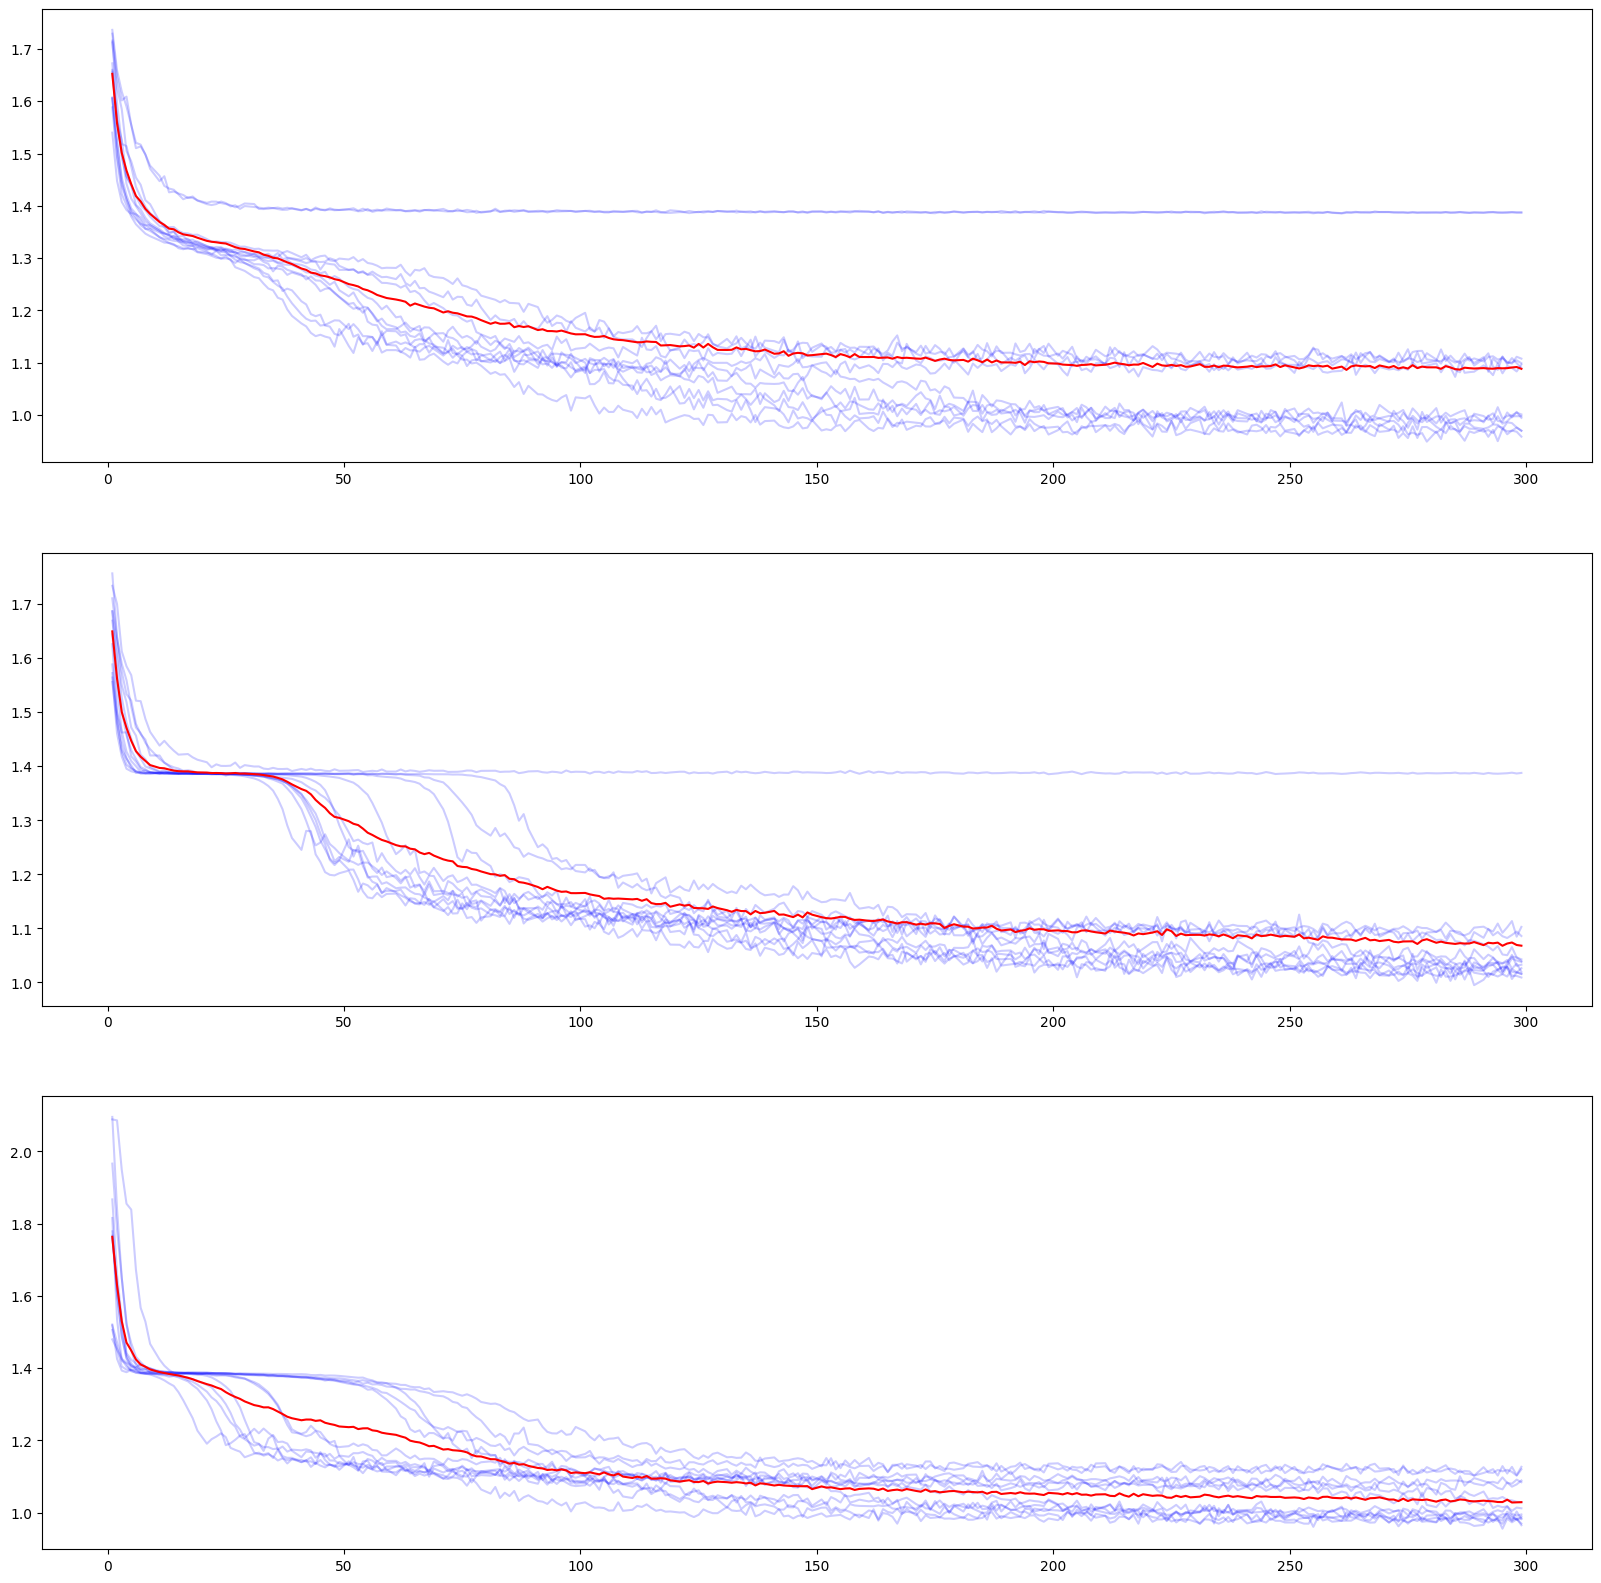

In [75]:
fig, axs = plt.subplots(3, 1, figsize=(20,20))

metric = "train_recon_loss"

result = pd.DataFrame.from_dict(gcn_results)
means = None
for idx in range(experiments_per):
    row = result.loc[result["idx"] == idx]
    axs[0].plot(row["step"], row[metric], c="blue", alpha=0.2)
    means = means + row[metric].to_numpy() if means is not None else row[metric].to_numpy()
axs[0].plot(row["step"], means / experiments_per, c="red")

result = pd.DataFrame.from_dict(gat_results)
means = None
for idx in range(experiments_per):
    row = result.loc[result["idx"] == idx]
    axs[1].plot(row["step"], row[metric], c="blue", alpha=0.2)
    means = means + row[metric].to_numpy() if means is not None else row[metric].to_numpy()
axs[1].plot(row["step"], means / experiments_per, c="red")

result = pd.DataFrame.from_dict(sage_results)
means = None
for idx in range(experiments_per):
    row = result.loc[result["idx"] == idx]
    axs[2].plot(row["step"], row[metric], c="blue", alpha=0.2)
    means = means + row[metric].to_numpy() if means is not None else row[metric].to_numpy()
axs[2].plot(row["step"], means / experiments_per, c="red")

plt.show()

In [68]:
from itertools import combinations
import random
def cosine_similarity(z, n_samples=10000):
    #all_index_pairs = list(combinations(range(z.shape[0]), 2)) # Get indeces of all pairs of vectors
    #print(torch.nn.functional.cosine_similarity(z[0], z[1], dim=0))
    sampled_index_pairs = [(random.choice(range(z.shape[0])), random.choice(range(z.shape[0]))) for _ in range(n_samples)]
    sampled_cosine_similarities = torch.tensor([torch.nn.functional.cosine_similarity(z[idx1], z[idx2], dim=0) for (idx1,idx2) in sampled_index_pairs])
    return sampled_cosine_similarities.mean(), sampled_cosine_similarities.std()


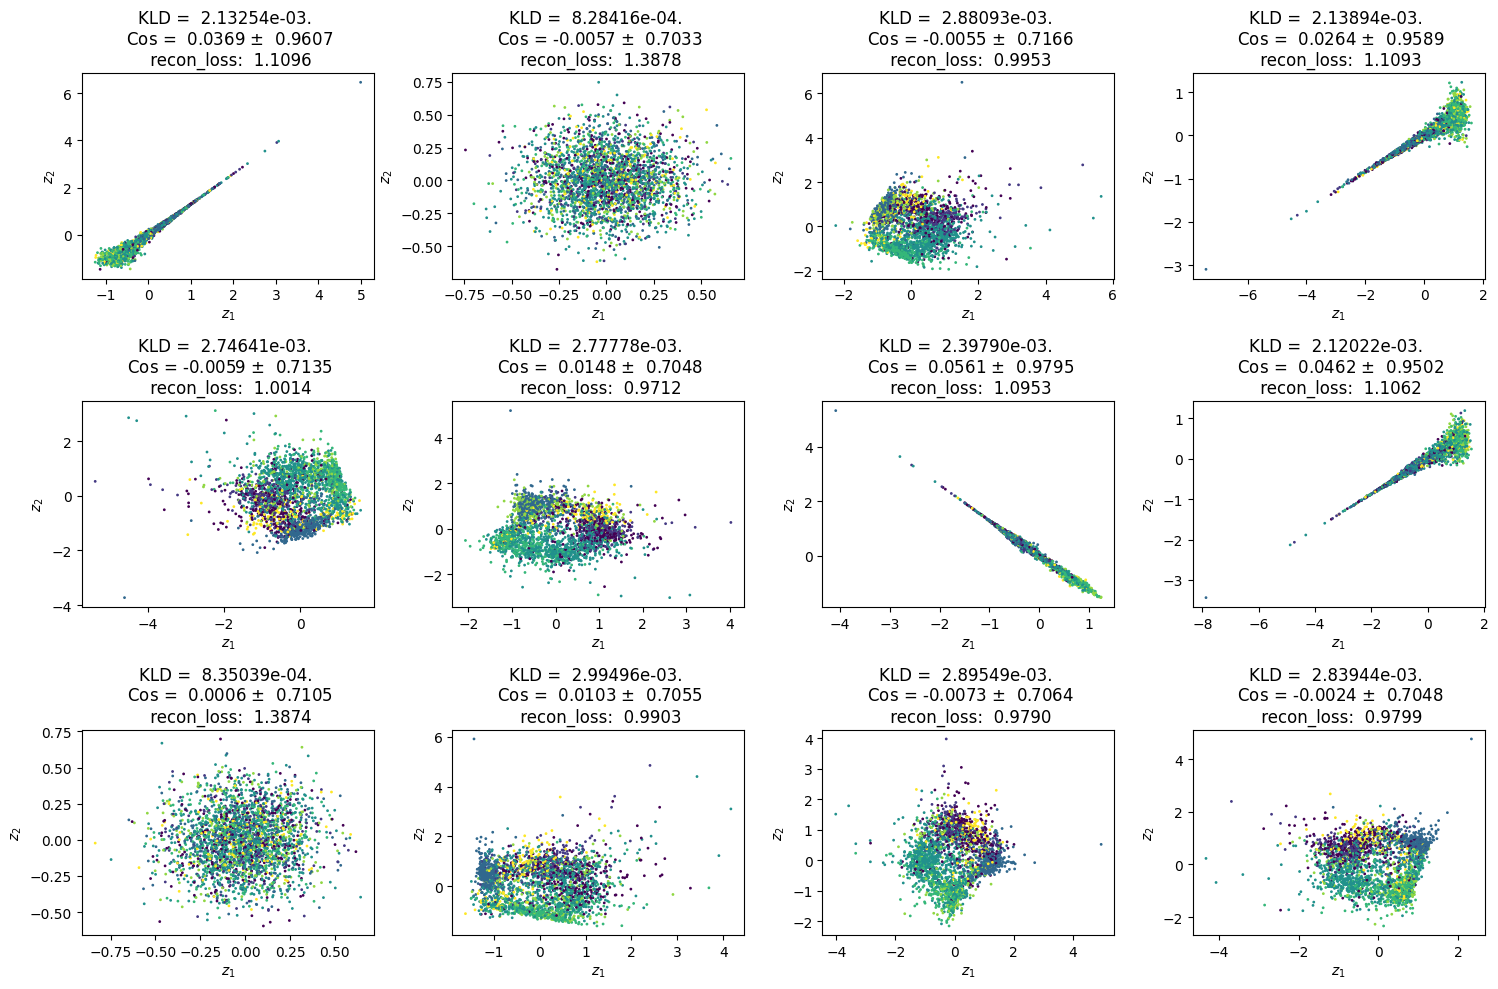

In [39]:
import os
fig, axs = plt.subplots(3,4, figsize=(15,10))
axs = axs.ravel()
desired_model = VariationalGCN
metric = "train_kld"

#fig.suptitle(desired_model.__name__, fontsize=32)
for model_path in os.listdir("repeat_experiment_models"):
    model_constructor = eval(model_path.split("_")[0].split("=")[1])
    #embedding_dim = int([p.split("=") for p in model_path.split("_") if p.split("=")[0] == "embeddingdim"][0][1])
    if model_constructor.__name__ is not desired_model.__name__:
        continue
    heads = int(model_path.split("heads=")[1].split("_")[0]) if "heads" in model_path else None
    aggr = model_path.split("aggr=")[1].split("_")[0].split("-")[0] if "aggr" in model_path else None
    if model_constructor.__name__ == "VariationalSAGE" and aggr == None:
        continue
    model = torch_geometric.nn.models.VGAE(model_constructor(dataset.num_features, embedding_dim, {
        "heads": heads,
        "aggr": aggr
    }))
    model_path = os.path.join("repeat_experiment_models", model_path)
    epochs = int(model_path.split("epochs=")[1].split("_idx=")[0])
    idx = int(model_path.split("idx=")[1])
    if epochs < 300:
        continue
    model.load_state_dict(torch.load(model_path, weights_only=True))
    with torch.no_grad():
        z = model.encode(test_data.x, test_data.edge_index)
        A = model.decode(z, test_data.edge_index)
        axs[idx].scatter(z[:,0],z[:,1], c=test_data.y, s=1)

        res = gcn_results if desired_model.__name__ == "VariationalGCN" else (gat_results if desired_model.__name__ == "VariationalGAT" else (sage_results if desired_model.__name__ == "VariationalSAGE" else None))
        result = pd.DataFrame(res)
        m = result.loc[result['idx'] == idx, metric].iloc[-1]
        cos_sim_mean, cos_sim_std = cosine_similarity(z)
        axs[idx].set_title(f"KLD = {m/test_data.num_nodes : .5e}. \n Cos = {cos_sim_mean : .4f} $\pm$ {cos_sim_std : .4f} \n recon_loss: {model.recon_loss(z, test_data.edge_index) : .4f}")
        axs[idx].set_xlabel("$z_1$")
        axs[idx].set_ylabel("$z_2$")
plt.tight_layout()
plt.savefig(f"{desired_model.__name__}-embeddings.png")
        #visualize_embedding(z, color=test_data.y, epoch=epochs, loss=torch.tensor(0))
        #plt.title(f"{model_constructor.__name__}, heads={heads}, aggr={aggr}")

tensor(0.9990) tensor(8.5611)
tensor(0.9983) tensor(7.5098)
tensor(1.1259) tensor(5.7380)
tensor(1.0841) tensor(6.6084)
tensor(0.9908) tensor(7.6635)
tensor(1.1242) tensor(5.5885)
tensor(0.9876) tensor(7.3845)
tensor(1.0533) tensor(7.2012)
tensor(0.9804) tensor(7.4673)
tensor(1.1027) tensor(6.5419)
tensor(1.0051) tensor(8.8837)
tensor(1.0205) tensor(8.4117)
tensor(1.1142) tensor(5.7366)
tensor(0.9934) tensor(7.7687)
tensor(1.1057) tensor(5.7364)
tensor(0.9962) tensor(7.4225)
tensor(0.9810) tensor(7.5062)
tensor(1.1000) tensor(6.4816)
tensor(1.1138) tensor(5.8119)
tensor(0.9911) tensor(8.0388)
tensor(0.9885) tensor(7.8493)
tensor(0.9803) tensor(7.6624)
tensor(1.0343) tensor(8.8314)
tensor(1.0193) tensor(7.5783)
tensor(1.0959) tensor(6.4376)
tensor(1.0374) tensor(8.4414)
tensor(1.1045) tensor(6.4480)
tensor(1.0273) tensor(6.9654)
tensor(1.0589) tensor(9.0973)
tensor(1.0375) tensor(7.7324)
tensor(1.0171) tensor(7.3547)
tensor(1.0246) tensor(7.0133)


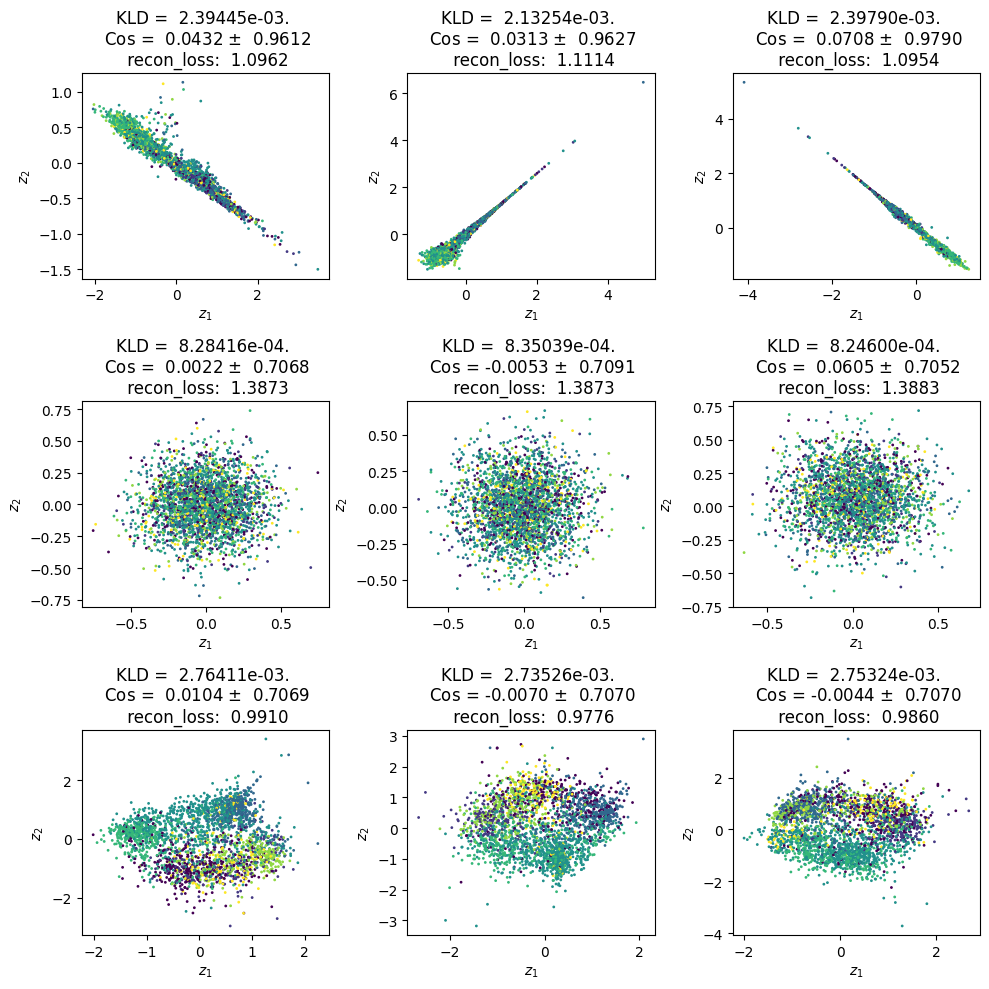

In [69]:

import os
fig, axs = plt.subplots(3,3, figsize=(10,10))
desired_model = VariationalGCN
metric = "train_kld"
shape = "cone" # "cone" | "cloud" | "mix"

#fig.suptitle(desired_model.__name__, fontsize=32)
for shape_idx, shape in enumerate(["cone", "cloud", "mix"]):
    i = 0
    for model_path in os.listdir("repeat_experiment_models"):
        if i > 2:
            break
        model_constructor = eval(model_path.split("_")[0].split("=")[1])
        #embedding_dim = int([p.split("=") for p in model_path.split("_") if p.split("=")[0] == "embeddingdim"][0][1])
        #if model_constructor.__name__ is not desired_model.__name__:
        #    continue
        heads = int(model_path.split("heads=")[1].split("_")[0]) if "heads" in model_path else None
        aggr = model_path.split("aggr=")[1].split("_")[0].split("-")[0] if "aggr" in model_path else None
        if model_constructor.__name__ == "VariationalSAGE" and aggr == None:
            continue
        model = torch_geometric.nn.models.VGAE(model_constructor(dataset.num_features, embedding_dim, {
            "heads": heads,
            "aggr": aggr
        }))
        model_path = os.path.join("repeat_experiment_models", model_path)
        epochs = int(model_path.split("epochs=")[1].split("_idx=")[0])
        idx = int(model_path.split("idx=")[1])
        if epochs < 300:
            continue
        model.load_state_dict(torch.load(model_path, weights_only=True))
        with torch.no_grad():
            z = model.encode(test_data.x, test_data.edge_index)
            A = model.decode(z, test_data.edge_index)
            cos_sim_mean, cos_sim_std = cosine_similarity(z, n_samples=30000)
            if shape == "cone" and cos_sim_mean < 0.03:
                continue
            recon_loss = model.recon_loss(z, test_data.edge_index)
            kld = model.kl_loss() 
            if shape == "cloud":
                if (recon_loss < 1.3 or kld > 6):
                    print(recon_loss, kld)
                    continue

            if shape == "mix" and (recon_loss > 1):
                continue
            axs[shape_idx, i].scatter(z[:,0],z[:,1], c=test_data.y, s=1)

            #res = gcn_results if desired_model.__name__ == "VariationalGCN" else (gat_results if desired_model.__name__ == "VariationalGAT" else (sage_results if desired_model.__name__ == "VariationalSAGE" else None))
            res = gcn_results + gat_results + sage_results
            result = pd.DataFrame(res)
            m = result.loc[(result['idx'] == idx) & (result['model'] == model_constructor.__name__), metric].iloc[-1]
            cos_sim_mean, cos_sim_std = cosine_similarity(z)
            axs[shape_idx, i].set_title(f"KLD = {m/test_data.num_nodes : .5e}. \n Cos = {cos_sim_mean : .4f} $\pm$ {cos_sim_std : .4f} \n recon_loss: {recon_loss : .4f}")
            axs[shape_idx, i].set_xlabel("$z_1$")
            axs[shape_idx, i].set_ylabel("$z_2$")
            i += 1
plt.tight_layout()
#plt.savefig(f"{desired_model.__name__}-embeddings.png")